In [66]:
import os
import tensorflow as tf
import keras
import cv2
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator 
import keras_utils
import random

1.14.0
2.3.1


In [3]:
MAN_DIR = "data/men"
WOMEN_DIR = "data/women"
IMG_SIZE = 300
DIR_LABEL = [(0,MAN_DIR),(1,WOMEN_DIR)]

# Loading and preprocessing images

In [4]:
train_images = []
labels = []
for label,_dir in DIR_LABEL:
    _dir += '/'
    for file in os.listdir(_dir):
        img = image.load_img(_dir+str(file),target_size=(IMG_SIZE,IMG_SIZE))
        img = image.img_to_array(img)
        img = img/255
        train_images.append(img)
        labels.append(label)

In [63]:
len(labels)

3330

### We can see a little imbalance in classes, but since this is the first version, let's leave everything as it is

In [68]:
pd.Series(labels).value_counts() 

1    1912
0    1418
dtype: int64

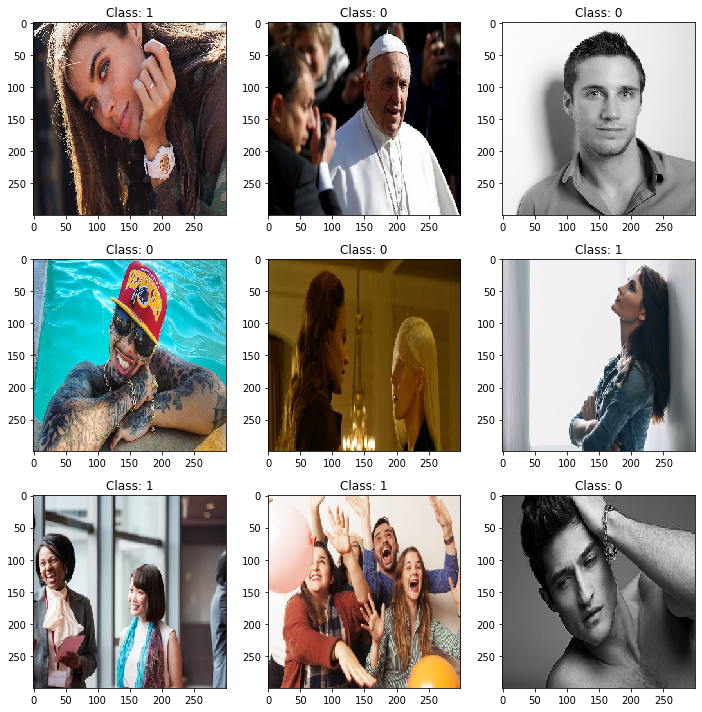

In [74]:
random_indices =  [random.randint(0, 3330) for i in range(9)]
plt.figure(figsize=(10,10))
for i, index in enumerate(random_indices):
    plt.subplot(3,3,i+1)
    plt.imshow(train_images[index], cmap='gray', interpolation='none')
    plt.title(f"Class: {labels[index]}")
    plt.tight_layout()

# Training simple CNN

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train,X_test,y_train,y_test = train_test_split(np.array(train_images),np.array(labels),test_size=0.1,random_state=17)

In [9]:
X_train.shape, X_test.shape, y_test.shape

((2997, 300, 300, 3), (333, 300, 300, 3), (333,))

In [10]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,AveragePooling2D
from keras.layers.advanced_activations import LeakyReLU

In [11]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    
    # (Conv + ReLU)*2 + MaxPooling 
    model.add(Conv2D(32,(3,3),input_shape=(300,300,3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64,(3,3)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.1))

    # (Conv + ReLU)*2 + MaxPooling 
    model.add(Conv2D(128,(3,3)))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(256,(3,3)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.1))

    # Conv + ReLU + MaxPooling
    model.add(Conv2D(256,(3,3)))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((3,3)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.2))

    model.add(Dense(1,activation='sigmoid'))
    
    return model

In [12]:
model = make_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 298, 298, 32)      896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 298, 298, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 296, 296, 64)      18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 296, 296, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 128)     

In [75]:
model.compile(
    loss='binary_crossentropy',  
    optimizer='rmsprop',  
    metrics=['accuracy']
)

In [24]:
model_filename = 'MenWomen.{0:03d}.hdf5'
last_finished_epoch = None

### With this lines we can continue training our model from last finished epoch

In [ ]:
#from keras.models import load_model
#s = reset_tf_session()
# last_finished_epoch = 27
# model = load_model(model_filename.format(last_finished_epoch))

In [ ]:
history = model.fit(
    X_train,y_train,batch_size=32,epochs=28,validation_split=0.2,
    callbacks=[
        keras_utils.TqdmProgressCallback(),
        keras_utils.ModelSaveCallback(model_filename)
    ],
    initial_epoch=last_finished_epoch or 0)

In [ ]:
# save weights to file
model.save_weights("weights.h5")

# Evaluation

In [82]:
model.load_weights("weights.h5")

In [59]:
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix

In [42]:
preds = model.predict_classes(X_test)

In [78]:
classification_report(y_test,preds,output_dict=True)

{'0': {'precision': 0.6956521739130435,
  'recall': 0.5797101449275363,
  'f1-score': 0.6324110671936759,
  'support': 138},
 '1': {'precision': 0.7339449541284404,
  'recall': 0.8205128205128205,
  'f1-score': 0.774818401937046,
  'support': 195},
 'accuracy': 0.7207207207207207,
 'macro avg': {'precision': 0.7147985640207419,
  'recall': 0.7001114827201784,
  'f1-score': 0.7036147345653609,
  'support': 333},
 'weighted avg': {'precision': 0.7180758740391768,
  'recall': 0.7207207207207207,
  'f1-score': 0.7158027497010548,
  'support': 333}}

In [61]:
confusion_matrix(y_test,preds)

array([[ 80,  58],
       [ 35, 160]], dtype=int64)

In [47]:
roc_auc_score(y_test,preds)

0.7001114827201783

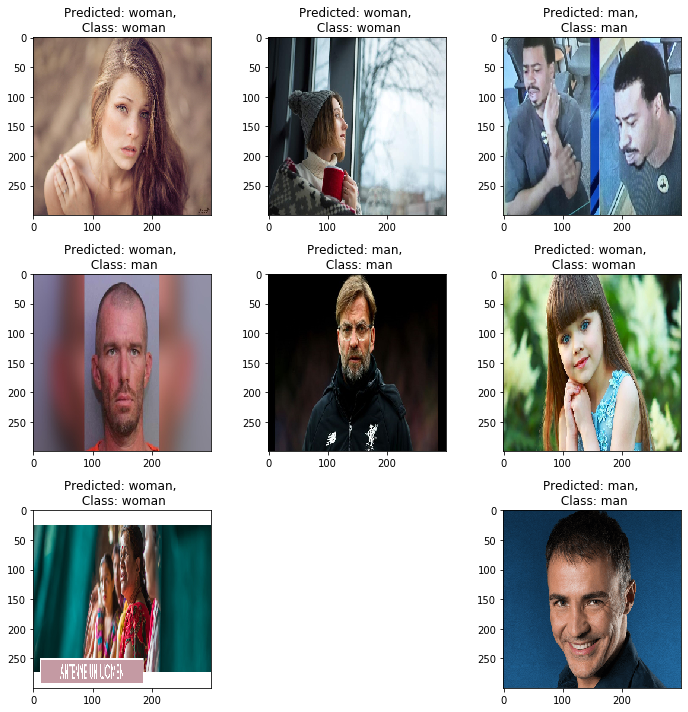

In [72]:
random_indices = [random.randint(0, 300) for i in range(9)]
plt.figure(figsize=(10,10))
for i, index in enumerate(random_indices):
    pred = preds[index]
    pred = 'man' if pred==0 else 'woman'
    actual = 'man' if y_test[index]==0 else 'woman'
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[index], cmap='gray', interpolation='none')
    plt.title(f"Predicted: {pred}, \n Class: {actual}")
    plt.tight_layout()

### Let's check classification report for our train data

In [83]:
y_train_pred = model.predict_classes(X_train)

In [86]:
classification_report(y_train,y_train_pred,output_dict=True)
#Due to small train data we can see that our model is quite overfitted

{'0': {'precision': 0.9387576552930884,
  'recall': 0.83828125,
  'f1-score': 0.8856789104416013,
  'support': 1280},
 '1': {'precision': 0.8883495145631068,
  'recall': 0.959231217239371,
  'f1-score': 0.922430691683002,
  'support': 1717},
 'accuracy': 0.9075742409075742,
 'macro avg': {'precision': 0.9135535849280976,
  'recall': 0.8987562336196855,
  'f1-score': 0.9040548010623016,
  'support': 2997},
 'weighted avg': {'precision': 0.9098785169436128,
  'recall': 0.9075742409075742,
  'f1-score': 0.9067342352302182,
  'support': 2997}}

### Next step: fine tuning pretrained model

In [ ]:
# Will be updated